# Telco Churn Classification Project

### Overview:

### Goals:
    1. Identify primary drivers of churn
    2. Demonstrate impact of driver on churn through a model minimizing false negatives (use Recall)
    3. Present recommendations to address churn driver
    
## 1. Planning
    a. Acquire, prep and explore data
    b. Build hypothesis
    c. Isolate range in monthly charges where spikes of churn are occuring.
    d. Identify feature most often found in those spikes of churn.
    e. Determine if feature and churn are significantly associated (Chi Square)
    f. Rule out feature being significantly associated with other features (Chi Square)
    g. Fit best models to predict churn based on these features
    h. Extract takeaways:
        - Extent of churn due to isolated features
        - Churn further irritated by what other features
        - Ability to predict churn given which features
    i. Develop recommendations


In [1]:
# standard ds imports
import numpy as np
import pandas as pd

# for wrangling and exploration
import acquire
import prepare
import explore
import model

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for statistical analysis
import scipy.stats as stats

# for model evaluation
import sklearn.metrics as met
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#filter out noise
import warnings
warnings.filterwarnings('ignore')

## 2. Data Aquisition and Preparation

In [2]:
telco = acquire.get_telco_data()
telco = prepare.prep_telco(telco)
train, val, test = prepare.split_data(telco, 'churn')
train.shape, val.shape, test.shape

((4225, 25), (1409, 25), (1409, 25))

In [3]:
train['extras'] = train['online_security'] + train['online_backup']+train['device_protection']+train['tech_support']+ train['streaming_tv']+train['streaming_movies']
train = train.drop(columns=['online_security', 'online_backup', 'device_protection','tech_support','streaming_tv','streaming_movies'])

## 3. Data Exploration

#### Hypothesis 1 - Monthly Charges:

    Ho -> There is a less than or equal probability of churn if a customer has monthly charges over $70
    Ha -> There is a greater probability of churn if a customer has monthly charges over $70

Two sample, one tail
T-Test of churn vs not churn monthly charges

#### Hypothesis 2 - Fiber Optic:

    Ho -> There is no association between a customer having fiber optic and a customer churning
    Ha -> There is an association between a customer having fiber optic and a customer churning

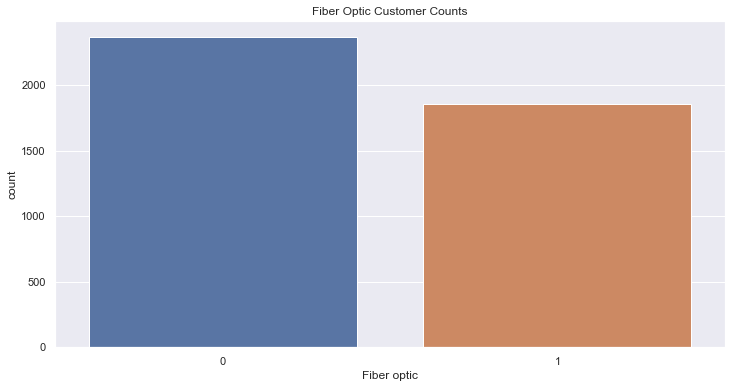

2370 customers or 56.1% do not have fiber optic.
1855 customers or 43.9% have fiber optic.

---------------------------------------------------------------------------------------------------------------



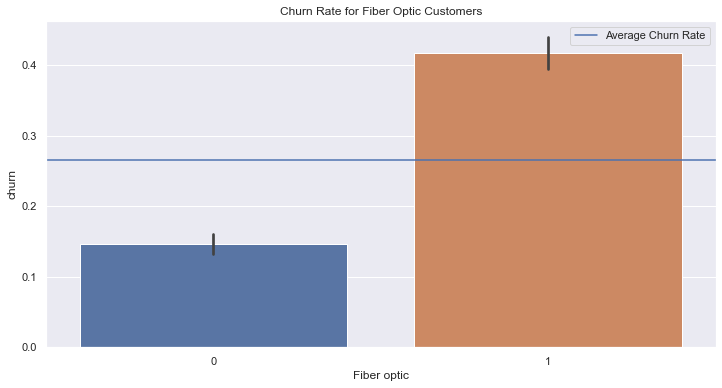

14.7% of all customers without fiber optic churn.
41.7% of all customers with fiber optic churn.


In [4]:
# plot the count of customers in the train dataset against the fiber optic feature
plt.figure(figsize=(12,6))
sns.countplot(x='Fiber optic', data=train)
plt.title('Fiber Optic Customer Counts')
plt.show()

# calculate the count of customers with and without fiber optic
no_fo = train[['Fiber optic']].value_counts()[0]
yes_fo = train[['Fiber optic']].value_counts()[1]

# calculate the percentage of customers with and without fiber optic
no_fo_per = round((train[['Fiber optic']].value_counts(normalize=True)*100)[0], 1)
yes_fo_per = round((train[['Fiber optic']].value_counts(normalize=True)*100)[1], 1)

# print the previously calculated values in statements
print(f'{no_fo} customers or {no_fo_per}% do not have fiber optic.')
print(f'{yes_fo} customers or {yes_fo_per}% have fiber optic.')

# make some space between graphs
print('')
print('---------------------------------------------------------------------------------------------------------------')
print('')

# plot the feature fiber optic against the target of churn
plt.figure(figsize=(12,6))
sns.barplot(data=train, x='Fiber optic', y='churn')
# add a line for average rate of churn in the train data set (regardless of features)
rate = train.churn.mean()
plt.axhline(rate, label= 'Average Churn Rate')
plt.legend()
plt.title('Churn Rate for Fiber Optic Customers')
plt.show()

# calculate the churn rate for customers with and without fiber optic
yes_churn_fo_per = round(((train[(train['Fiber optic']==1)&(train.churn)==1].shape[0]) / (train[train['Fiber optic'] == 1].shape[0]))*100, 1)
no_churn_fo_per = round(((train[(train['Fiber optic']==0)&(train.churn)==1].shape[0]) / (train[train['Fiber optic'] == 0].shape[0]))*100, 1)

# print the previous calulations in statements
print(f'{no_churn_fo_per}% of all customers without fiber optic churn.')
print(f'{yes_churn_fo_per}% of all customers with fiber optic churn.')

##### Chi Square Test: Fiber Optic vs Churn

In [5]:
# set up variables. Customers with fiber optic vs customers without. 
fiber = train[train['Fiber optic']==1]
no_fiber = train[train['Fiber optic']==0]

# create observed dataset
observed = pd.crosstab(train['Fiber optic'], train.churn)

# set alpha to 0.05 (due to 95% confidence level)
α = 0.05

observed

churn,0,1
Fiber optic,,
0,2022,348
1,1082,773


In [6]:
# run chi square test
chi2, p, dof, expected = stats.chi2_contingency(observed)
if p < α:
    print('''Reject the null hypothesis.
    Findings suggest there is an association between a customer having fiber optic and a customer churning''')
else:
    print('''Fail to reject the null hypothesis.
    Findings suggest there is no association between a customer having fiber optic and a customer churning.''')

Reject the null hypothesis.
    Findings suggest there is an association between a customer having fiber optic and a customer churning


#### Hypothesis 3 - Tenure:

    Ho -> There is a less than or equal probability of churn if a customer has tenure under 18 years
    Ha -> There is a greater probability of churn if a customer has tenure under 18 years

In [7]:
α = 0.05
observed = pd.crosstab(train.tenure, train.churn)
chi2, p, dof, expected = stats.chi2_contingency(observed)
p < α

True

In [15]:
# average tenure length of churned customers
train[train.churn == 1].tenure.mean()

18.28278322925959

In [9]:
train[train.churn ==1].tenure.median()

10.0

In [10]:
train[train.churn ==1].tenure.describe()

count    1121.000000
mean       18.282783
std        19.605515
min         1.000000
25%         2.000000
50%        10.000000
75%        30.000000
max        72.000000
Name: tenure, dtype: float64

In [11]:
# looking for % of customers that churn with 18 or less years of tenure
train[train.tenure <= 18].churn.sum()/train[train.tenure <= 18].shape[0]

0.4399756246191347

In [12]:
train[train.tenure > 15].churn.sum()/train[train.tenure > 15].shape[0]

0.16046681254558717

#### Bring it all together

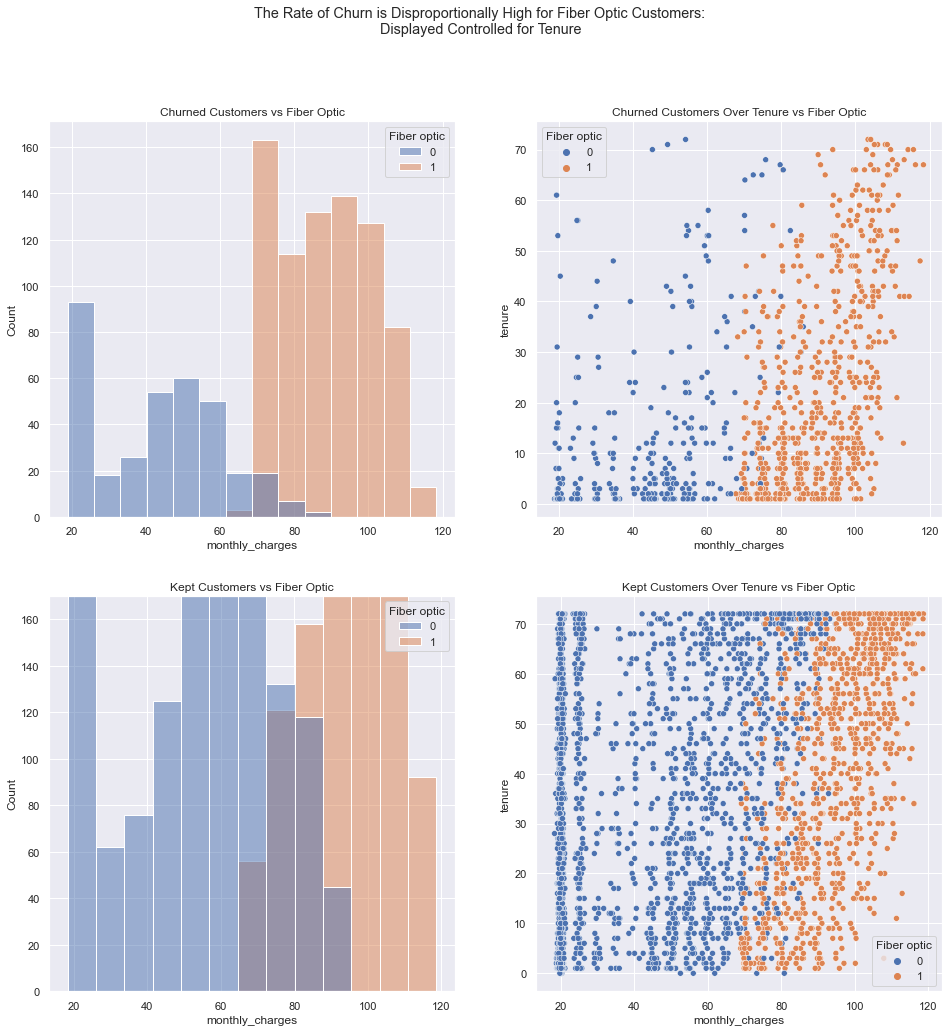

In [13]:
fig, axes = plt.subplots(2,2, figsize=(16,16))
fig.suptitle('''The Rate of Churn is Disproportionally High for Fiber Optic Customers: 
Displayed Controlled for Tenure''')

# Churning customers, no matter where in tenure, are churning the most when they have fiber optic. 
axes[0,0].set_title('Churned Customers vs Fiber Optic')
axes[0,1].set_title('Churned Customers Over Tenure vs Fiber Optic')
axes[1,0].set_title('Kept Customers vs Fiber Optic')
axes[1,1].set_title('Kept Customers Over Tenure vs Fiber Optic')

sns.histplot(ax=axes[0,0], data=train[train.churn == 1], x='monthly_charges', hue='Fiber optic')
sns.scatterplot(ax=axes[0,1], data=train[(train.churn == 1)], y='tenure', x='monthly_charges', hue='Fiber optic')
sns.histplot(ax=axes[1,0], data=train[train.churn == 0], x='monthly_charges', hue='Fiber optic')
axes[1,0].set_ylim(0,170)
sns.scatterplot(ax=axes[1,1], data=train[(train.churn == 0)], y='tenure', x='monthly_charges', hue='Fiber optic')
plt.show()
# would look further into when customers (get fiber optic vs their churn date) vs (non-fiber optic vs churn date)

## 4. Data Modeling

## 5. Model Evaluation

# CONCLUSTION

### Goals and how reached:

### Key Findings: 
 - Customers with more than 18 years of tenure and fiber optic are most likely to churn. 

### Recommendations: 
 - Target fiber optic customers around the 10 year mark and evaluate satisfaction level with their services. 

### Next Steps:
 - look into when customers are adding fiber optic to their plan and if/when they are churning
 - look into possible reasons why fiber optic is causing this increase in churn (functionality, price, etc.)